## Open a Mexican Restaurant in Seoul

1. Get the District and population data from Wikipedia : https://en.wikipedia.org/wiki/List_of_districts_of_Seoul
2. Make the District data with the population


In [2]:
#!pip install geopy
#!pip install geocoder
#!pip install folium
#!pip install sklearn
#!pip install bs4

In [3]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt # for graphical usage 

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
from folium import plugins
from folium.plugins import HeatMap

# main documentation page: http://beautiful-soup-4.readthedocs.io/en/latest/
# how to use the BeautifulSoup package: https://www.youtube.com/watch?v=ng2o98k983k video
from bs4 import BeautifulSoup 
import pandas as pd
import requests

print('Libraries imported.')

Libraries imported.


In [14]:
#Import the newyork_data.json

with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
#NYC neighborhood data

ny_neighborhood_data = newyork_data['features']

column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']

nyc_neighborhoods = pd.DataFrame(columns = column_names)

for i in ny_neighborhood_data:
    borough = neighborhood = i['properties']['borough']
    neighborhood = i['properties']['name']
    
    latitude = i['geometry']['coordinates'][1]
    longitude = i['geometry']['coordinates'][0]
    
    nyc_neighborhoods = nyc_neighborhood.append({'Borough' : borough, 'Neighborhood' : neighborhood, 'Latitude' : latitude, 'Longitude': longitude}, ignore_index = True)
    
nyc_neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [13]:
# get coordinates of Bucharest
nyc_address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(nyc_address)
latitude = location.latitude
longitude = location.longitude
nyc_center = [latitude, longitude]
print('The geograpical coordinate of {} are {}, {}.'.format(nyc_address, latitude, longitude))

The geograpical coordinate of New York City, NY are 40.7127281, -74.0060152.


In [15]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10, 
                         min_zoom=9, max_zoom=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(nyc_neighborhoods['Latitude'], 
                                           nyc_neighborhoods['Longitude'], 
                                           nyc_neighborhoods['Borough'], 
                                           nyc_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        weight=2,
        color='#333333',
        fill=True,
        fill_color='#ffb300',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

In [18]:
CLIENT_ID = 'BVNTD5Y4YBP5VGGRKHYI3AWXUOKVLUVDHC1DIH3RYPGVDCY2' # your Foursquare ID
CLIENT_SECRET = 'L5UETPVE5WADNBEP1WI5VIKQIJEIHWKMB0R5EPARKJA01ZFV' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: BVNTD5Y4YBP5VGGRKHYI3AWXUOKVLUVDHC1DIH3RYPGVDCY2
CLIENT_SECRET:L5UETPVE5WADNBEP1WI5VIKQIJEIHWKMB0R5EPARKJA01ZFV


In [20]:
neighborhood_name = nyc_neighborhoods.loc[0, 'Neighborhood']
neighborhood_lat = nyc_neighborhoods.loc[0, 'Latitude']
neighborhood_lng = nyc_neighborhoods.loc[0, 'Longitude']

radius = 500
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID,
                                                                                                                           CLIENT_SECRET, VERSION, neighborhood_lat, neighborhood_lng, radius, LIMIT)

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    """
    A function that retrieves information about venues in each neighborhood.
    It takes as input a list of the names of the neighborhoods, a list of 
    their latitudes, and a list of their longitudes.
    It returns a dataframe with information about each neighborhood and its venues.
    """
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print('•', end='')
            
        # create the API request URL
        url = ('https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}'
               '&v={}&ll={},{}&intent=browse&radius={}&limit={}'
               .format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT))
            
        # make the GET request
        results = None
        while results is None:
            try:
                results = requests.get(url).json()["response"]["venues"]
            except:
                print('X', end='')
                results = None
        
        # return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng, v['name'], v['location']['lat'], 
                             v['location']['lng'], v['categories'][0]['name']) 
                            for v in results if len(v['categories']) > 0])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 
                             'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return(nearby_venues)

def get_category_type(row):
    try:
        categories_list = row['categories']
    except: 
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [30]:
nyc_venues = getNearbyVenues(names=nyc_neighborhoods['Neighborhood'],
                             latitudes=nyc_neighborhoods['Latitude'],
                             longitudes=nyc_neighborhoods['Longitude']
                            )

•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••

In [31]:
nyc_venues.groupby('Neighborhood').count()

print('There are {} uniques categories.'.format(len(nyc_venues['Venue Category'].unique())))



There are 586 uniques categories.


In [32]:
#one hot encoding
nyc_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nyc_onehot['Neighborhood'] = nyc_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [nyc_onehot.columns[-1]] + list(nyc_onehot.columns[:-1])
nyc_onehot = nyc_onehot[fixed_columns]

nyc_onehot.head()

,Neighborhood,ATM,Accessories Store,Acupuncturist,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Gate,Airport Service,Airport Terminal,Airport Tram,Alternative Healer,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Auditorium,Australian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Baggage Claim,Baggage Locker,Bakery,Ballroom,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Bathing Area,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buddhist Temple,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Center,Business Service,Butcher,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campaign Office,Campground,Canal,Candy Store,Cantonese Restaurant,Capitol Building,Car Wash,Caribbean Restaurant,Carpet Store,Casino,Caucasian Restaurant,Cemetery,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Circus,City Hall,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College & University,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Basketball Court,College Bookstore,College Cafeteria,College Classroom,College Communications Building,College Football Field,College Gym,College Lab,College Library,College Math Building,College Quad,College Rec Center,College Residence Hall,College Science Building,College Soccer Field,College Stadium,College Technology Building,College Theater,College Track,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Community Center,Community College,Concert Hall,Conference Room,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Corporate Amenity,Corporate Cafeteria,Cosmetics Shop,Costume Shop,Country Dance Club,Courthouse,Coworking Space,Credit Union,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Currency Exchange,Cycle Studio,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,EV Charging Station,Eastern European Restaurant,Electronics Store,Elementary School,Embassy / Consulate,Emergency Room,Empanada Restaurant,Entertainment Service,Escape Room,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fire Station,Fish & Chips Shop,Fish Market,Fishing Spot,Fishing Store,Flea Market,Floating Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Forest,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Funeral Home,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Himalayan Restaurant,Hindu Temple,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hospital,Hospita

In [33]:
nyc_onehot.shape

(26750, 587)

In [35]:
nyc_grouped = nyc_onehot.groupby('Neighborhood').mean().reset_index()
nyc_grouped.head(5)

,Neighborhood,ATM,Accessories Store,Acupuncturist,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Gate,Airport Service,Airport Terminal,Airport Tram,Alternative Healer,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Auditorium,Australian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Baggage Claim,Baggage Locker,Bakery,Ballroom,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Bathing Area,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buddhist Temple,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Center,Business Service,Butcher,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campaign Office,Campground,Canal,Candy Store,Cantonese Restaurant,Capitol Building,Car Wash,Caribbean Restaurant,Carpet Store,Casino,Caucasian Restaurant,Cemetery,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Circus,City Hall,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College & University,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Basketball Court,College Bookstore,College Cafeteria,College Classroom,College Communications Building,College Football Field,College Gym,College Lab,College Library,College Math Building,College Quad,College Rec Center,College Residence Hall,College Science Building,College Soccer Field,College Stadium,College Technology Building,College Theater,College Track,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Community Center,Community College,Concert Hall,Conference Room,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Corporate Amenity,Corporate Cafeteria,Cosmetics Shop,Costume Shop,Country Dance Club,Courthouse,Coworking Space,Credit Union,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Currency Exchange,Cycle Studio,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,EV Charging Station,Eastern European Restaurant,Electronics Store,Elementary School,Embassy / Consulate,Emergency Room,Empanada Restaurant,Entertainment Service,Escape Room,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fire Station,Fish & Chips Shop,Fish Market,Fishing Spot,Fishing Store,Flea Market,Floating Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Forest,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Funeral Home,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Himalayan Restaurant,Hindu Temple,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hospital,Hospita

In [36]:
# Print the top 10 most common venues

num_top_venues = 10

for hood in nyc_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = nyc_grouped[nyc_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')    

----Allerton----
                venue  freq
0  Salon / Barbershop  0.05
1     Laundry Service  0.04
2            Bus Line  0.04
3          Non-Profit  0.03
4            Car Wash  0.03
5         Gas Station  0.03
6                Food  0.03
7            Pharmacy  0.03
8        Chiropractor  0.03
9       Deli / Bodega  0.02


----Annadale----
                 venue  freq
0   Salon / Barbershop  0.07
1          Pizza Place  0.07
2           Nail Salon  0.04
3        Tattoo Parlor  0.04
4  American Restaurant  0.04
5              Butcher  0.02
6           Restaurant  0.02
7                 Pool  0.02
8               Bakery  0.02
9                  Spa  0.02


----Arden Heights----
                         venue  freq
0  Professional & Other Places  0.05
1                         Pool  0.05
2             Dentist's Office  0.04
3              Doctor's Office  0.04
4                         Road  0.04
5           Salon / Barbershop  0.04
6           Italian Restaurant  0.03
7                

In [37]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [39]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = nyc_grouped['Neighborhood']

for ind in np.arange(nyc_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nyc_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Salon / Barbershop,Laundry Service,Bus Line,Pharmacy,Car Wash,Non-Profit,Food,Chiropractor,Gas Station,Residential Building (Apartment / Condo)
1,Annadale,Salon / Barbershop,Pizza Place,Tattoo Parlor,Nail Salon,American Restaurant,Bar,Building,Veterinarian,Gas Station,General Entertainment
2,Arden Heights,Pool,Professional & Other Places,Dentist's Office,Salon / Barbershop,Road,Doctor's Office,Gym,Food,Medical Center,Bar
3,Arlington,Church,Bus Stop,Road,Building,Hardware Store,Salon / Barbershop,Professional & Other Places,Automotive Shop,Residential Building (Apartment / Condo),Boat or Ferry
4,Arrochar,Bus Stop,Deli / Bodega,Bus Line,Laundry Service,Pizza Place,Food Truck,Bar,Beach,Dry Cleaner,Bagel Shop


In [40]:
#Clustering
# set number of clusters
kclusters = 5

nyc_grouped_clustering = nyc_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 2, 2, 1, 2, 2, 2])

In [41]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

nyc_merged = nyc_neighborhoods

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
nyc_merged = nyc_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

nyc_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,4,Salon / Barbershop,Church,Laundry Service,Doctor's Office,Coworking Space,Playground,Food,School,Gas Station,Residential Building (Apartment / Condo)
1,Bronx,Co-op City,40.874294,-73.829939,2,Bus Line,Residential Building (Apartment / Condo),School,Church,Other Great Outdoors,Parking,Salon / Barbershop,Bus Station,High School,Doctor's Office
2,Bronx,Eastchester,40.887556,-73.827806,2,Automotive Shop,Bus Line,Caribbean Restaurant,Deli / Bodega,Gas Station,Miscellaneous Shop,Church,Salon / Barbershop,Bridge,Hardware Store
3,Bronx,Fieldston,40.895437,-73.905643,2,College Residence Hall,College Administrative Building,Synagogue,Residential Building (Apartment / Condo),Office,College Quad,College Gym,Other Great Outdoors,Tech Startup,School
4,Bronx,Riverdale,40.890834,-73.912585,1,Residential Building (Apartment / Condo),Synagogue,Doctor's Office,Park,Playground,Dog Run,General College & University,Bus Station,Beach Bar,Pool


In [42]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_merged['Latitude'], nyc_merged['Longitude'], nyc_merged['Neighborhood'],nyc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Toronto data acquistion and mapping


In [43]:
wikiurl = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
response = requests.get(wikiurl).text

soup = BeautifulSoup(response, 'lxml')

canada_data = soup.find('table')
canada_data_rows = canada_data.tbody.find_all("tr")

#df = pd.read_html(str(canada_data))

df = []
for tr in canada_data_rows:
    td = tr.find_all("td")
    row = [tr.text for tr in td]
    
    if row!=[] and row[1] != "Not assigned":
        if "Not assigned" in row [2]:
            row[2] = row[1]
        df.append(row)
    
df_can = pd.DataFrame(df, columns = ["Postal Code", "Borough", "Neighborhood"])

#Remove the \n at the end of components
df_can["Neighborhood"] = df_can["Neighborhood"].str.replace("\n", "")
df_can["Postal Code"] = df_can["Postal Code"].str.replace("\n", "")
df_can["Borough"] = df_can["Borough"].str.replace("\n", "")

#Remove the row where Borough is 'Not assigned'
df_can = df_can[df_can['Borough']!='Not assigned']

df_can.head(5)

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [44]:
#Grouping the data
df_can = df_can.groupby(["Postal Code", "Borough"])["Neighborhood"].apply(", ".join).reset_index()
df_can.head()

,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [45]:
#!pip install geocoder
import geocoder # import geocoder

postal_code = df_can.iloc[:,0]

def get_geocode(postal_code):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
        lat_lng_coords = g.latlng

        latitude = lat_lng_coords[0]
        longitude = lat_lng_coords[1]
    return latitude, longitude

In [46]:
geo_df = pd.read_csv('http://cocl.us/Geospatial_data')
geo_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [47]:
geo_can = pd.merge(geo_df, df_can, on = 'Postal Code')

#Change the df columns
geo_can = geo_can[['Postal Code', 'Borough', 'Neighborhood', 'Latitude', 'Longitude']]
geo_can.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


## Clustering and Analyzing Data


In [48]:
import numpy as np
import pandas as pd

import json
import requests

from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans
import folium

print('Libraries imported!')


Libraries imported!


In [59]:
address = 'Toronto'

geolocator = Nominatim(user_agent = "ny_explorer")
tor_location = geolocator.geocode(address)
tor_lat = location.latitude
tor_long = location.longitude

print('The geograpical coordinate of Toronto City are {}, {}'.format(tor_lat, tor_long))

The geograpical coordinate of Toronto City are 40.7127281, -74.0060152


In [60]:
map_toronto = folium.Map(location=[tor_lat, tor_long], zoom_start = 10)

#Add markers to map
for lat, lng, borough, neighborhood, p_code in zip(geo_can['Latitude'], geo_can['Longitude'], geo_can['Borough'], geo_can['Neighborhood'], geo_can['Postal Code']):
    label = '{}, {}, {}'.format(neighborhood, borough, p_code)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng], radius = 5,
        popup = label, color = 'blue',
        fill = True, fill_color = '#3186cc', fill_opacity = 0.5, parse_html = False).add_to(map_toronto)
    
map_toronto

In [56]:
neighborhood_name = geo_can.loc[1, 'Neighborhood']
neighborhood_lat = geo_can.loc[1, 'Latitude']
neighborhood_lng = geo_can.loc[1, 'Longitude']

radius = 500
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID,
                                                                                                                           CLIENT_SECRET, VERSION, neighborhood_lat, neighborhood_lng, radius, LIMIT)

In [57]:
tor_results = requests.get(url).json()

In [58]:
venues = tor_results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(10)

<ipython-input-58-ca16616ff24e>:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # flatten JSON


,name,categories,lat,lng
0,RIGHT WAY TO GOLF,Golf Course,43.785177,-79.161108
1,Chris Effects Painting,Construction & Landscaping,43.784343,-79.163742
2,Royal Canadian Legion,Bar,43.782533,-79.163085


In [61]:
tor_venues = getNearbyVenues(geo_can['Neighborhood'], geo_can['Latitude'], geo_can['Longitude'])

•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••

In [62]:
tor_venues.head(5)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Rouge Park - Woodland Trail,43.801782,-79.200427,Trail
1,"Malvern, Rouge",43.806686,-79.194353,Shell,43.803227,-79.192414,Gas Station
2,"Malvern, Rouge",43.806686,-79.194353,Alvin Curling Public School,43.808683,-79.190103,Elementary School
3,"Malvern, Rouge",43.806686,-79.194353,Dupont Canada,43.805927,-79.197695,Building
4,"Malvern, Rouge",43.806686,-79.194353,Tim Hortons,43.802000,-79.198169,Coffee Shop


In [63]:
tor_venues.groupby('Neighborhood').size()

Neighborhood
Agincourt                                                                                                                                  93
Alderwood, Long Branch                                                                                                                     93
Bathurst Manor, Wilson Heights, Downsview North                                                                                            89
Bayview Village                                                                                                                            88
Bedford Park, Lawrence Manor East                                                                                                          87
Berczy Park                                                                                                                                84
Birch Cliff, Cliffside West                                                                                                            

In [86]:
# one hot encoding
tor_onehot = pd.get_dummies(tor_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
# we used Neighborhood_" instead of just "Neighborhood" because
# there is a venue category called "Neighborhood"
tor_onehot['Neighborhood'] = tor_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [tor_onehot.columns[-1]] + list(tor_onehot.columns[:-1])
tor_onehot = tor_onehot[fixed_columns]

tor_onehot.head()

,Neighborhood,ATM,Accessories Store,Acupuncturist,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,Alternative Healer,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Studio,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Auditorium,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Baggage Claim,Bakery,Ballroom,Bank,Bar,Baseball Field,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Blood Donation Center,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Center,Business Service,Butcher,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campaign Office,Campground,Candy Store,Cantonese Restaurant,Capitol Building,Car Wash,Caribbean Restaurant,Casino,Cemetery,Cha Chaan Teng,Cheese Shop,Chinese Breakfast Place,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,City Hall,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College & University,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Basketball Court,College Bookstore,College Cafeteria,College Classroom,College Communications Building,College Engineering Building,College Football Field,College Gym,College History Building,College Hockey Rink,College Lab,College Library,College Quad,College Rec Center,College Residence Hall,College Science Building,College Soccer Field,College Stadium,College Technology Building,College Theater,College Track,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Conference Room,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Corporate Cafeteria,Corporate Coffee Shop,Cosmetics Shop,Costume Shop,Country Dance Club,Courthouse,Coworking Space,Credit Union,Cuban Restaurant,Cultural Center,Cupcake Shop,Currency Exchange,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,EV Charging Station,Eastern European Restaurant,Electronics Store,Elementary School,Embassy / Consulate,Emergency Room,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fire Station,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Flight School,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Frame Store,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Funeral Home,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Hindu Temple,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hospital Ward,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Housing Development,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Industrial Estate,Insurance Office,Internet Cafe,Intersect

In [87]:

tor_grouped = tor_onehot.groupby('Neighborhood').mean().reset_index()
tor_grouped.head()

,Neighborhood,ATM,Accessories Store,Acupuncturist,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,Alternative Healer,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Studio,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Auditorium,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Baggage Claim,Bakery,Ballroom,Bank,Bar,Baseball Field,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Blood Donation Center,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Center,Business Service,Butcher,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campaign Office,Campground,Candy Store,Cantonese Restaurant,Capitol Building,Car Wash,Caribbean Restaurant,Casino,Cemetery,Cha Chaan Teng,Cheese Shop,Chinese Breakfast Place,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,City Hall,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College & University,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Basketball Court,College Bookstore,College Cafeteria,College Classroom,College Communications Building,College Engineering Building,College Football Field,College Gym,College History Building,College Hockey Rink,College Lab,College Library,College Quad,College Rec Center,College Residence Hall,College Science Building,College Soccer Field,College Stadium,College Technology Building,College Theater,College Track,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Conference Room,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Corporate Cafeteria,Corporate Coffee Shop,Cosmetics Shop,Costume Shop,Country Dance Club,Courthouse,Coworking Space,Credit Union,Cuban Restaurant,Cultural Center,Cupcake Shop,Currency Exchange,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,EV Charging Station,Eastern European Restaurant,Electronics Store,Elementary School,Embassy / Consulate,Emergency Room,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fire Station,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Flight School,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Frame Store,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Funeral Home,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Hindu Temple,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hospital Ward,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Housing Development,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Industrial Estate,Insurance Office,Internet Cafe,Intersect

In [88]:
num_top_cat = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_cat):
    try:
        columns.append('{}{} Most Common Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Category'.format(ind+1))

# create a new dataframe
tor_neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
tor_neighborhoods_categories_sorted['Neighborhood'] = tor_grouped['Neighborhood']

for ind in np.arange(tor_grouped.shape[0]):
    tor_neighborhoods_categories_sorted.iloc[ind, 1:] = return_most_common_venues(
        tor_grouped.iloc[ind, :], num_top_cat)

tor_neighborhoods_categories_sorted.head()

,Neighborhood,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,Agincourt,Automotive Shop,Building,Office,Church,Auto Garage,Doctor's Office,Chinese Restaurant,Coffee Shop,Storage Facility,Furniture / Home Store
1,"Alderwood, Long Branch",Office,Dentist's Office,Medical Center,Conference Room,Bank,Salon / Barbershop,Daycare,Gas Station,Pub,Asian Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Residential Building (Apartment / Condo),Doctor's Office,Synagogue,Medical Center,Office,Bank,Laundry Service,Convenience Store,Coffee Shop,Ice Cream Shop
3,Bayview Village,Residential Building (Apartment / Condo),Doctor's Office,Church,Park,Office,Dog Run,School,Pharmacy,Intersection,Optical Shop
4,"Bedford Park, Lawrence Manor East",Salon / Barbershop,Italian Restaurant,Sushi Restaurant,Restaurant,Spa,Juice Bar,Boutique,Coffee Shop,Gas Station,Medical Center


In [89]:
# set number of clusters
kclusters = 5

tor_grouped_clustering = tor_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 0, 4, 2, 2, 0, 2, 4, 1, 3])

In [93]:
# add clustering labels
tor_neighborhoods_categories_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

tor_merged = geo_can.rename(columns={'Neighborhood': 'Neighborhood'}).copy()

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
tor_merged = tor_merged.join(tor_neighborhoods_categories_sorted.set_index('Neighborhood'), on='Neighborhood')

tor_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,1,Office,Automotive Shop,Salon / Barbershop,Factory,Building,Dentist's Office,Doctor's Office,Coffee Shop,Caribbean Restaurant,Trail
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,1,Automotive Shop,Office,Medical Center,Salon / Barbershop,General Entertainment,Park,Miscellaneous Shop,Road,Trail,Chinese Restaurant
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,2,Residential Building (Apartment / Condo),Electronics Store,Restaurant,Church,Bus Line,Thrift / Vintage Store,School,Salon / Barbershop,Medical Center,Road
3,M1G,Scarborough,Woburn,43.770992,-79.216917,2,Cosmetics Shop,Coffee Shop,Residential Building (Apartment / Condo),Convenience Store,Pizza Place,Indian Restaurant,Bus Stop,Building,Pharmacy,Salon / Barbershop
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,1,Doctor's Office,Building,Medical Center,Bakery,Automotive Shop,Sporting Goods Shop,Office,Dentist's Office,Residential Building (Apartment / Condo),Salon / Barbershop


In [94]:

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9,
                          min_zoom=8, max_zoom=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for lat, lon, poi, cluster in zip(tor_merged['Latitude'], tor_merged['Longitude'], 
                                  tor_merged['Neighborhood'], tor_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        weight=1,
        popup=label,
        color='#333333',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

### Examining the Cluster

In [95]:
tor_merged.loc[tor_merged['Cluster Labels'] == 0, 
               tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
26,North York,0,Office,Building,Medical Center,Café,Coworking Space,Tech Startup,Doctor's Office,Church,Automotive Shop,Sandwich Place
27,North York,0,Office,Building,Medical Center,Café,Coworking Space,Tech Startup,Doctor's Office,Church,Automotive Shop,Sandwich Place
29,North York,0,Office,Medical Center,Automotive Shop,Furniture / Home Store,Doctor's Office,Government Building,Fraternity House,Optical Shop,Gas Station,Salon / Barbershop
53,Downtown Toronto,0,Office,Automotive Shop,Furniture / Home Store,Coffee Shop,Italian Restaurant,Art Gallery,Building,Food Truck,Road,Moving Target
55,Downtown Toronto,0,Office,Event Space,Residential Building (Apartment / Condo),Building,Nightclub,Furniture / Home Store,Japanese Restaurant,Other Nightlife,Rental Car Location,Road
56,Downtown Toronto,0,Office,Building,Road,Residential Building (Apartment / Condo),Parking,Hotel,Movie Theater,Lounge,Laundry Service,Korean Restaurant
58,Downtown Toronto,0,Office,Building,Café,Coffee Shop,Food Court,Vegetarian / Vegan Restaurant,Indian Restaurant,Bike Rental / Bike Share,Ballroom,Pool
60,Downtown Toronto,0,Office,Coffee Shop,Park,Restaurant,Café,Building,Event Space,Italian Restaurant,Parking,Cosmetics Shop
61,Downtown Toronto,0,Office,Financial or Legal Service,Coffee Shop,Salon / Barbershop,Food Court,Building,Bakery,Café,Video Game Store,Bus Stop
69,Downtown Toronto,0,Office,Building,Residential Building (Apartment / Condo),Tech Startup,Gym,Pub,Bar,Hotel,Road,Parking


### Most common venue in NYC


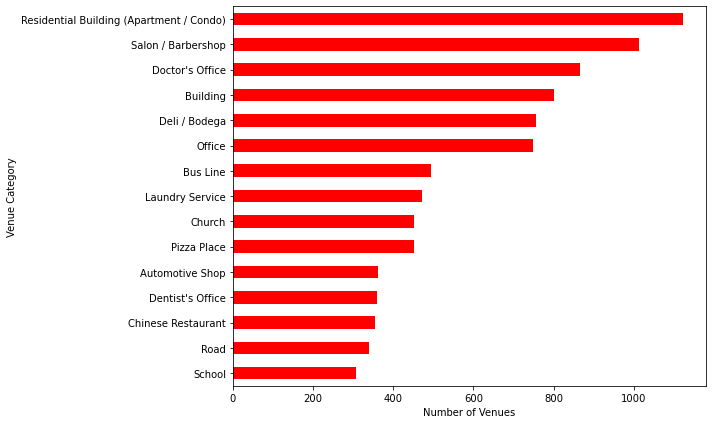

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
nyc_top_vc = nyc_venues['Venue Category'].value_counts(normalize=False)
ax = nyc_top_vc.head(15).plot(kind='barh', color='r');
ax.invert_yaxis()
ax.set_ylabel('Venue Category')
ax.set_xlabel('Number of Venues')
plt.tight_layout()
fig.savefig('most-common-ven-nyc.png', dpi=300)

### Most common venue in Toronto

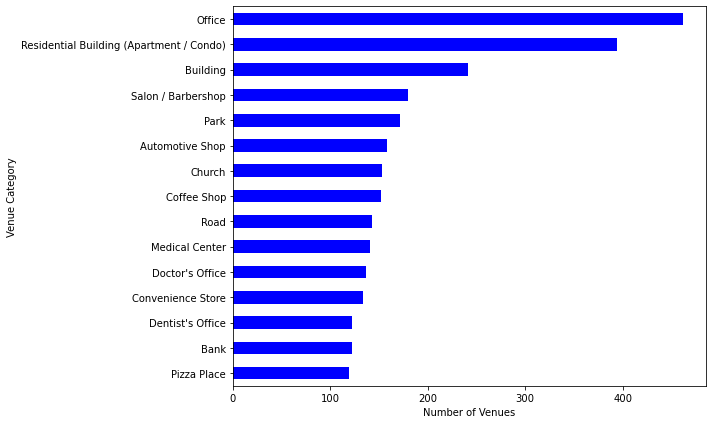

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
tor_top_vc = tor_venues['Venue Category'].value_counts(normalize=False)
ax = tor_top_vc.head(15).plot(kind='barh', color='b');
ax.invert_yaxis()
ax.set_ylabel('Venue Category')
ax.set_xlabel('Number of Venues')
plt.tight_layout()
fig.savefig('most-common-ven-tor.png', dpi=300)

### Common Venue categories in NYC

302 neighborhoods in NYC


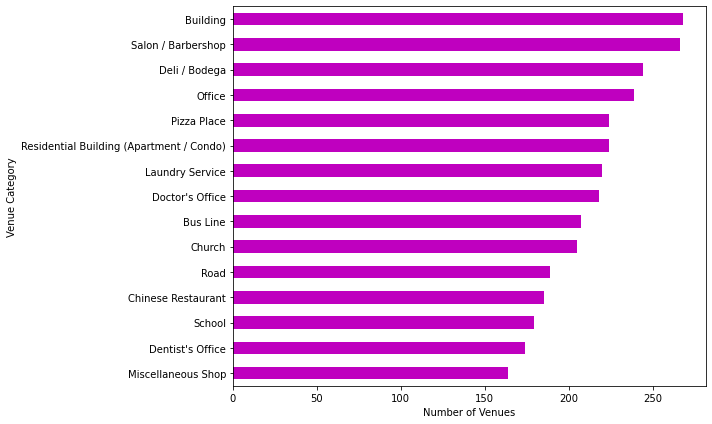

In [84]:
fig, ax = plt.subplots(1,1 ,figsize=(10,6))
nyc_g = nyc_onehot.groupby('Neighborhood').max().reset_index()
nyc_p = nyc_g.drop('Neighborhood', axis=1).sum().sort_values(ascending=False)
print("{} neighborhoods in NYC".format(nyc_g.shape[0]))
ax = nyc_p.head(15).plot(kind='barh', color='m');
ax.invert_yaxis()
ax.set_ylabel('Venue Category')
ax.set_xlabel('Number of Venues')
plt.tight_layout()
fig.savefig('most-common2-ven-nyc.png', dpi=300)

### Most Common Venue Categories in Toronto

99 neighborhoods in NYC


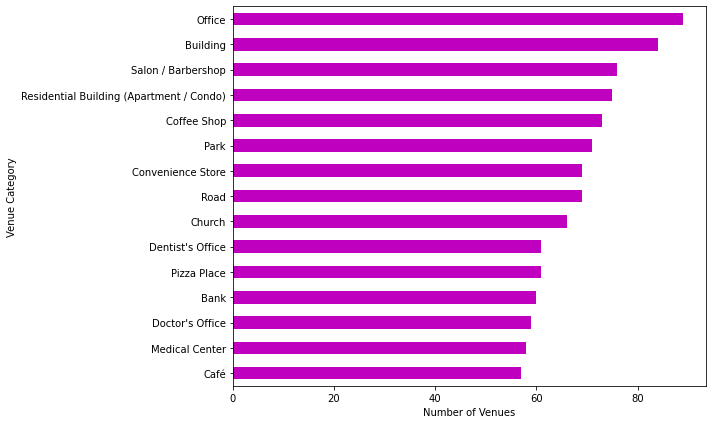

In [96]:
fig, ax = plt.subplots(1,1 ,figsize=(10,6))
tor_g = tor_onehot.groupby('Neighborhood').max().reset_index()
tor_p = tor_g.drop('Neighborhood', axis=1).sum().sort_values(ascending=False)
print("{} neighborhoods in NYC".format(tor_g.shape[0]))
ax = tor_p.head(15).plot(kind='barh', color='m');
ax.invert_yaxis()
ax.set_ylabel('Venue Category')
ax.set_xlabel('Number of Venues')
plt.tight_layout()
fig.savefig('most-common2-ven-tor.png', dpi=300)